<a href="https://colab.research.google.com/github/strange007/docker/blob/main/Copy_of_Fine_Tune_LLAMA_2_Using_QLoRA_Quantization_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview of the SFFT and RLHF:
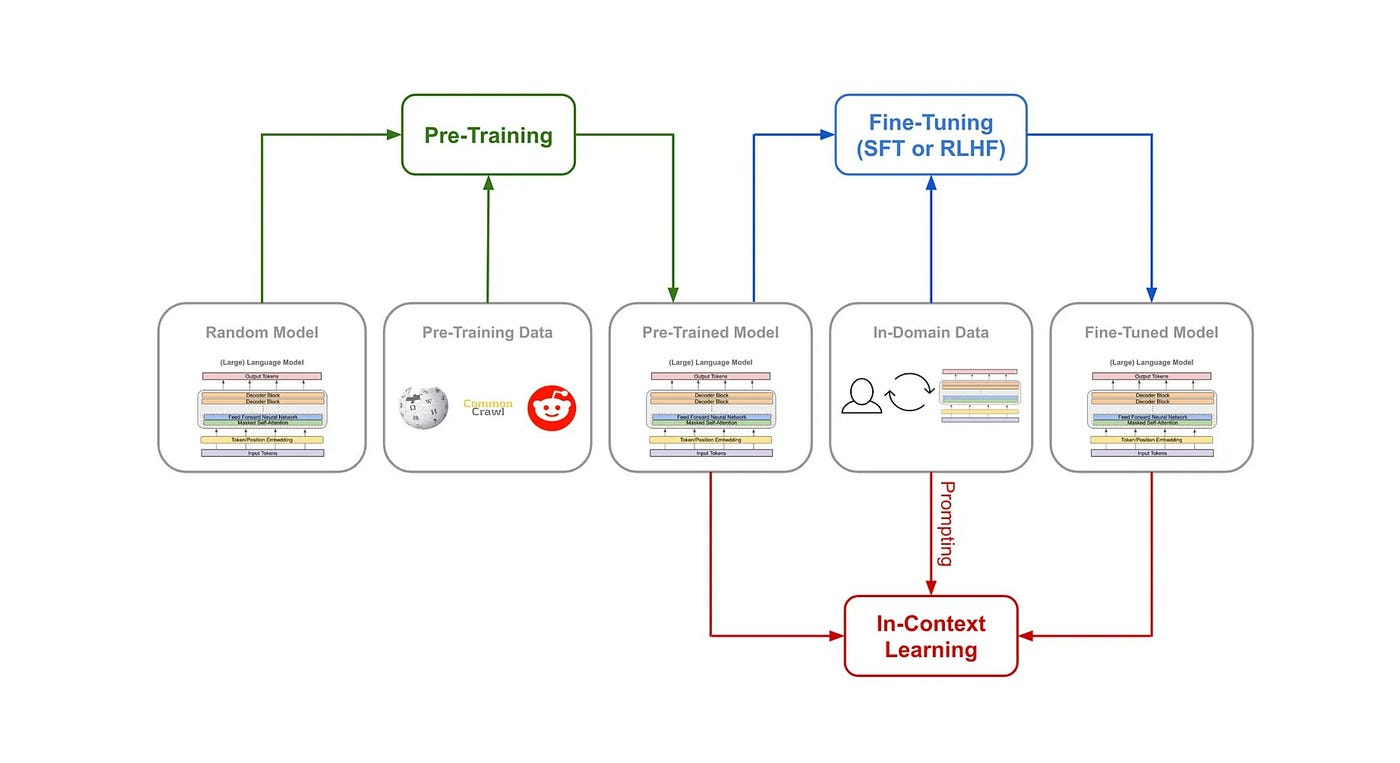

In [ ]:
!pip install -q -U bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install transformers==4.31
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets
!pip install evaluate
!pip install -qqq trl==0.7.1

In [ ]:
import torch
import time
import evaluate
import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset
import random

In [ ]:
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

dataset


###  Preprocess the Dialog-Summary Dataset

You need to convert the dialog-summary (prompt-response) pairs into explicit instructions for the LLM. Prepend an instruction to the start of the dialog with `Summarize the following conversation` and to the start of the summary with `Summary` as follows:

Training prompt (dialogue):
```
Summarize the following conversation.

    Chris: This is his part of the conversation.
    Antje: This is her part of the conversation.
    
Summary:
```

Training response (summary):
```
Both Chris and Antje participated in the conversation.
```

Then preprocess the prompt-response dataset into tokens and pull out their `input_ids` (1 per token).

In [ ]:
def format_instruction(dialogue: str, summary: str):
	return f"""### Instruction:
Summarize the following conversation.

### Input:
{dialogue.strip()}

### Summary:
{summary}
""".strip()


In [ ]:
def generate_instruction_dataset(data_point):

    return {
        "dialogue": data_point["dialogue"],
        "summary": data_point["summary"],
        "text": format_instruction(data_point["dialogue"],data_point["summary"])
    }

In [ ]:
def process_dataset(data: Dataset):
    return (
        data.shuffle(seed=42)
        .map(generate_instruction_dataset).remove_columns(['id', 'topic',])
    )

In [ ]:
# sample_dataset = dataset.filter(lambda example, index: index % 100 == 0, with_indices=True)

Filter:   0%|          | 0/12460 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:

# sample_dataset["train"] = process_dataset(sample_dataset["train"])
# sample_dataset["test"] = process_dataset(sample_dataset["validation"])
# sample_dataset["validation"] = process_dataset(sample_dataset["validation"])

In [ ]:
## APPLYING PREPROCESSING ON WHOLE DATASET
dataset["train"] = process_dataset(dataset["train"])
dataset["test"] = process_dataset(dataset["validation"])
dataset["validation"] = process_dataset(dataset["validation"])
# Select 1000 rows from the training split
train_data = dataset['train'].shuffle(seed=42).select([i for i in range(500)])

# Select 100 rows from the test and validation splits
test_data = dataset['test'].shuffle(seed=42).select([i for i in range(50)])
validation_data = dataset['validation'].shuffle(seed=42).select([i for i in range(50)])

train_data,test_data,validation_data

In [ ]:
sample_dataset["train"]["text"][0]

"### Instruction:\nBelow is a conversation between different person or humans. Write a summary of the conversation.\n\n### Input:\n#Person1#: Hello, Anna speaking!\n#Person2#: Hey, Anna, this is Jason.\n#Person1#: Jason, where have you been hiding lately? You know it's been a long time since your last call. Have you been good?\n#Person2#: Yes. How are you, Anna?\n#Person1#: I am fine. What have you been doing?\n#Person2#: Working. I've been really busy these days. I got a promotion.\n#Person1#: That's great, congratulations!\n#Person2#: Thanks. I am feeling pretty good about myself too. You know, bigger office, a raise and even an assistant.\n#Person1#: That's good. So I guess I'll have to make an appointment to see you.\n#Person2#: You are kidding.\n#Person1#: How long have you been working there?\n#Person2#: A bit over two years. This is a fast-moving company, and seniority isn't the only factor in deciding promotions.\n#Person1#: How do you like your new boss?\n#Person2#: She is ver

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id =  "NousResearch/Llama-2-7b-hf"
# model_id = "meta-llama/Llama-2-13b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


## ZERO-SHOT INFERENCE WITH LLAMA-2 7B

In [ ]:
index = 0

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

### Input:
{dialogue}

### Summary:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=100,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

# Training Setup

### LoRA Explained
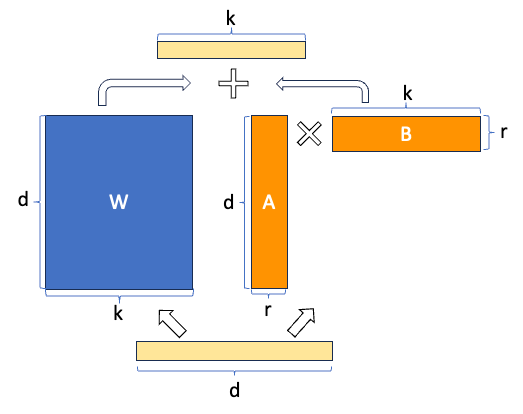

### Merging LoRA ADAPTER With BASE MODEL
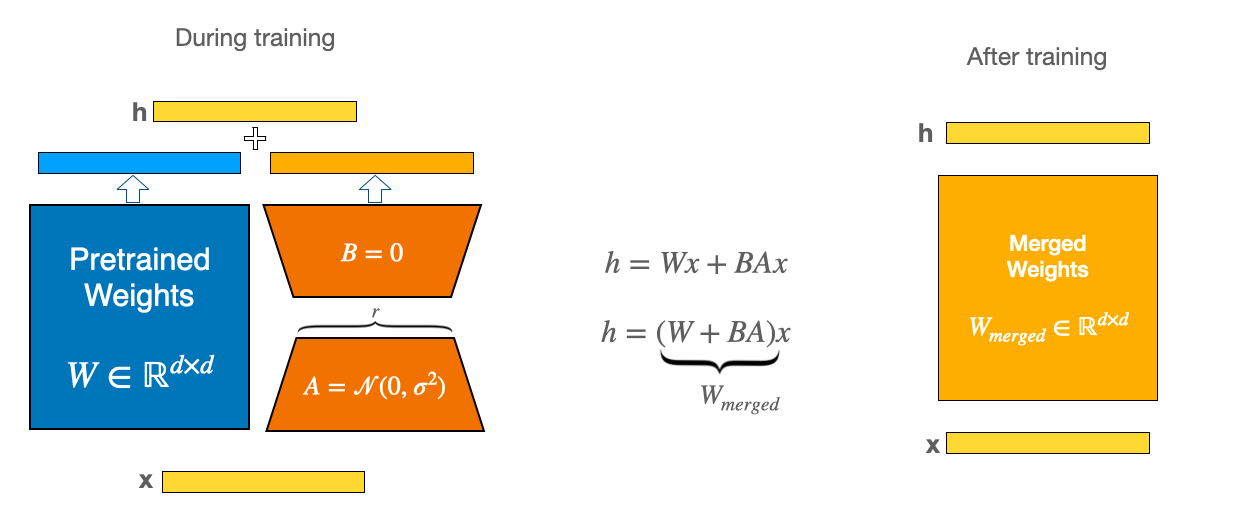

Then we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():

        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
print(model)

In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=64,
    # target_modules=["query_key_value"],
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], #specific to Llama models.
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
print_trainable_parameters(model)

trainable params: 16777216 || all params: 3517190144 || trainable%: 0.477006226934315


# Training

Run the cell below to run the training! For the sake of the demo, we just ran it for few steps just to showcase how to use this integration with existing tools on the HF ecosystem.

In [ ]:
OUTPUT_DIR = "llama2-docsum-adapter"

%load_ext tensorboard
%tensorboard --logdir llama2-docsum-adapter/runs

In [ ]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    logging_steps=1,
    learning_rate=1e-4,
    fp16=True,
    max_grad_norm=0.3,
    num_train_epochs=2,
    evaluation_strategy="steps",
    eval_steps=0.2,
    warmup_ratio=0.05,
    save_strategy="epoch",
    group_by_length=True,
    output_dir=OUTPUT_DIR,
    report_to="tensorboard",
    save_safetensors=True,
    lr_scheduler_type="cosine",
    seed=42,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


In [ ]:
from trl import SFTTrainer
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=validation_data,
    peft_config=lora_config,
    dataset_text_field="text",
    max_seq_length=1024,
    tokenizer=tokenizer,
    args=training_arguments,
)

trainer.train()

In [ ]:
peft_model_path="./peft-dialogue-summary"

trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

('./peft-dialogue-summary/tokenizer_config.json',
 './peft-dialogue-summary/special_tokens_map.json',
 './peft-dialogue-summary/tokenizer.json')

# Inference

In [ ]:
from transformers import TextStreamer
model.config.use_cache = True
model.eval()

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

peft_model_dir = "peft-dialogue-summary"

# load base LLM model and tokenizer
trained_model = AutoPeftModelForCausalLM.from_pretrained(
    peft_model_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
)
tokenizer = AutoTokenizer.from_pretrained(peft_model_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
index = 0

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

### Input:
{dialogue}

### Summary:
"""

input_ids = tokenizer(prompt, return_tensors='pt',truncation=True).input_ids.cuda()
# output = tokenizer.decode(
#     trained_model.generate(
#         inputs_ids,
#         max_new_tokens=100,
#     )[0],
#     skip_special_tokens=True
# )
outputs = trained_model.generate(input_ids=input_ids, max_new_tokens=100, )
output= tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'TRAINED MODEL GENERATED TEXT :\n{output}')

# Merge Trained LoRA Adapter With BASE MODEL and Push Model to Hub

---



In [ ]:
trained_model = AutoPeftModelForCausalLM.from_pretrained(
    peft_model_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
)
# Merge LoRA and base model
merged_model = trained_model.merge_and_unload()

# Save the merged model
merged_model.save_pretrained("merged_model",safe_serialization=True)
tokenizer.save_pretrained("merged_model")

# push merged model to the hub
# merged_model.push_to_hub("user/repo")
# tokenizer.push_to_hub("user/repo")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]